## FNO: Learning diffusivity (m) to solution (u) map for the Poisson problem

Data is located in `../data` directory, and key data of our interest is in `Poisson_FNO_samples.npz` file.

## On data
The Dropbox folder [NeuralOperator_Survey_Shared_Data_March2025](https://www.dropbox.com/scl/fo/5dg02otewg7j0bt7rhkuf/AOfAAc2SaWOgO-Yg25IlTXs?rlkey=t900geej8y8z327y5f8wu4yc9&st=t9c8qimk&dl=0) contains the key data to reproduce the results in the survey paper. 

If you did not generate data by running `survey_work/problems/poisson/Poisson.ipynb`, consider copying the contents of dropbox folder `NeuralOperator_Survey_Shared_Data_March2025/survey_work/problems/poisson/data/` into `survey_work/problems/poisson/data/` before running this notebook.


### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results/neural_operator_prediction_comparison.png" width="800"> </p>

In [1]:
import sys
import os

import torch
import numpy as np

src_path = "../../src/"
sys.path.append(src_path + 'plotting/')
from field_plot import field_plot_grid
from plot_loss import plot_loss

sys.path.append(src_path + 'data/')
from dataMethods import DataProcessorFNO

sys.path.append(src_path + 'nn/fno/')
from torch_fno2d import FNO2D
import uq

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
data_folder = '../../../autodl-tmp/data/'
results_dir = data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Load data

In [3]:
num_train = 3500
num_test = 1000

num_Y_components = 1 # scalar field
out_coordinate_dimension = 2 # domain for output function is 2D

coarsen_grid_factor = 1 # select every coarsen_grid_factor-th point so that we can coarsen the grid

# training hyperparameters
batch_size = 20
epochs = 500
lr = 1.0e-3

data_prefix = 'Poisson'
data = DataProcessorFNO(data_folder + data_prefix + '_FNO_samples_no-ood.npz', num_train, num_test, num_Y_components, coarsen_grid_factor)

train_data = {'X_train': data.X_train, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'Y_train': data.Y_test}

# get data to save
data_to_save = data.get_data_to_save()

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)

X_train: torch.Size([3500, 51, 51, 3])
Y_train: torch.Size([3500, 51, 51, 1])
X_test: torch.Size([1000, 51, 51, 3])
Y_test: torch.Size([1000, 51, 51, 1])


## Create model and train the network

In [4]:
num_layers = 3
width = 20 # dimension of hidden output space
fourier_modes1 = 8
fourier_modes2 = 8

model_save_path = results_dir + 'FNO/'
model_save_file = model_save_path + 'model.pkl'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model = FNO2D(num_layers, width, fourier_modes1, fourier_modes2, \
              num_Y_components, save_file = model_save_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: {}'.format(trainable_params))

Using device: cuda
Number of trainable parameters: 154961


In [5]:
# save the data and info
data_to_save = data.get_data_to_save()
model_metadata = {  'data': data_to_save, \
                    'num_train': num_train, \
                    'num_test': num_test, \
                    'num_Y_components': num_Y_components, \
                    'out_coordinate_dimension': out_coordinate_dimension, \
                    'coarsen_grid_factor': coarsen_grid_factor, \
                    'num_layers': num_layers, \
                    'width': width, \
                    'fourier_modes1': fourier_modes1, \
                    'fourier_modes2': fourier_modes2, \
                    'epochs': epochs, \
                    'batch_size': batch_size, \
                    'lr': lr}

# attach it to the model
model.metadata = model_metadata


In [9]:
# Train
model.train(train_data, test_data, batch_size=batch_size, \
            epochs = epochs, lr = lr, \
            save_model = True, save_epoch = 100)

--------------------------------------------------
Starting training with 154961 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 4.134e-01, Test Loss (l2 squared): 2.270e-01, Time (sec): 1.649
--------------------------------------------------
--------------------------------------------------
Epoch:   100, Train Loss (l2 squared): 6.672e-03, Test Loss (l2 squared): 7.113e-03, Time (sec): 1.481
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 100
--------------------------------------------------
--------------------------------------------------
Epoch:   200, Train Loss (l2 squared): 4.735e-03, Test Loss (l2 squared): 4.583e-03, Time (sec): 1.799
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 200
----

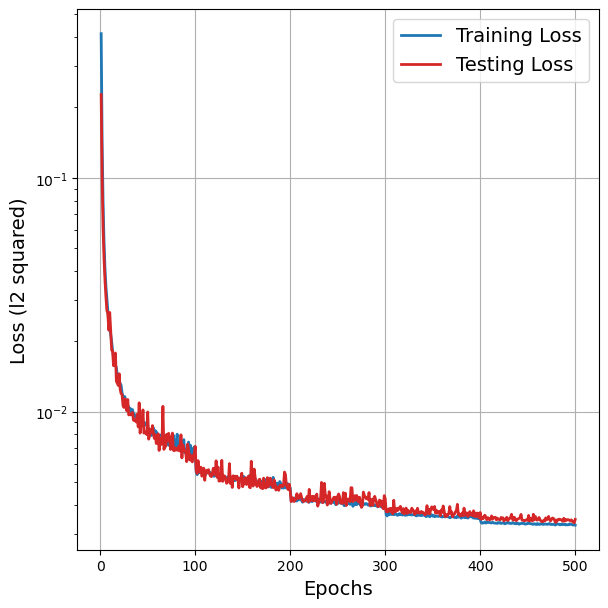

In [ ]:
## Plotting the loss history

plot_loss( model.train_loss_log[:, 0], \
           model.test_loss_log[:, 0], \
           fs = 14, lw = 2, \
           savefile = results_dir+'loss_his.png', \
           figsize = [7,7])

## Test and plot the output of network

In [11]:
# load the model
model = torch.load(model_save_file, weights_only=False)

In [ ]:
Y_test = test_data['Y_train'].detach().numpy()
Y_test_pred = model.predict(test_data['X_train']).detach().cpu().numpy()
print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))
a = Y_test.reshape(Y_test.shape[0], -1)
b = Y_test_pred.reshape(Y_test_pred.shape[0], -1)
print('a shape: {}, b shape: {}'.format(a.shape, b.shape))
error = np.linalg.norm(a - b, axis = 1)/np.linalg.norm(a, axis = 1)
print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (1000, 51, 51, 1), test_pred shape: (1000, 51, 51, 1)
a shape: (1000, 2601), b shape: (1000, 2601)
Num tests:  1000, Mean Loss (rel l2): 6.918e-02, Std Loss (rel l2): 2.186e-02


In [14]:
def apply_grid_dirichlet_bc(u, bc_value, bc_node_ids):
    u[bc_node_ids[:, 0], bc_node_ids[:,1]] = bc_value
    return u

i_plot =   993, error (rel l2): 4.050e-03
i_plot =   859, error (rel l2): 6.794e-03
i_plot =   298, error (rel l2): 4.282e-03
i_plot =   553, error (rel l2): 6.470e-03


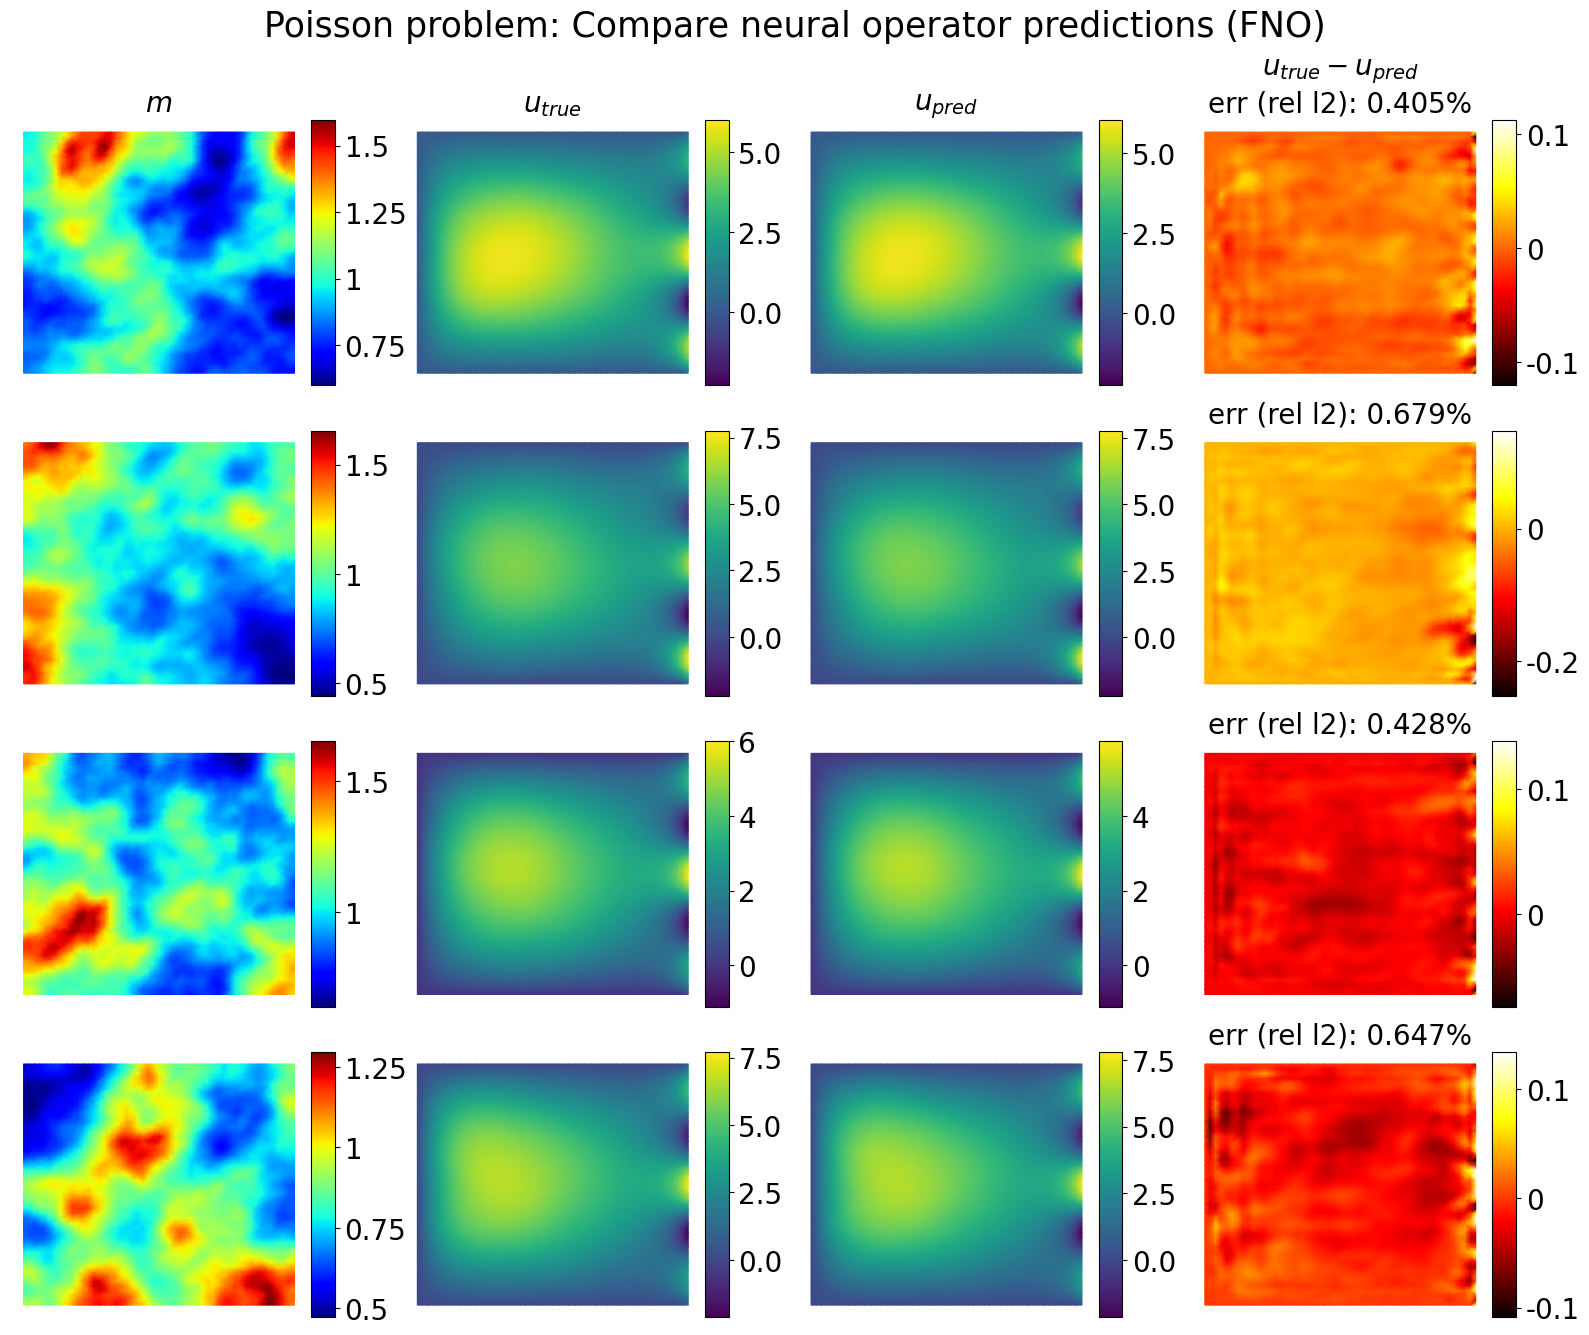

In [ ]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(17, 13))

decode = True
apply_dirichlet_bc_flag = True

# row: m, u_true, u_pred, u_diff
u_tags = [r'$m$', r'$u_{true}$', r'$u_{pred}$', r'$u_{true} - u_{pred}$']
cmaps = ['jet', 'viridis', 'viridis', 'hot']

grid_x, grid_y = data.grid_x_test[0], data.grid_y_test[0]

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred)[:, :, 0]
        i_truth = data.decoder_Y(i_truth)[:, :, 0]
        i_m_test = data.decoder_X(i_m_test)[:, :, 0]
    else:
        i_pred = i_pred[:, :, 0]
        i_truth = i_truth[:, :, 0]
        i_m_test = i_m_test[:, :, 0]
    if apply_dirichlet_bc_flag:
        i_pred = apply_grid_dirichlet_bc(i_pred, 0.0, data.u_grid_dirichlet_boundary_nodes)
        i_truth = apply_grid_dirichlet_bc(i_truth, 0.0, data.u_grid_dirichlet_boundary_nodes)
        # # verify for i_truth
        # a = i_truth[i, data.u_grid_dirichlet_boundary_nodes[:,0], data.u_grid_dirichlet_boundary_nodes[:,1]]
        # if np.abs(a).max() > 1.0e-9:
        #     print('Warning: Dirichlet BC not applied to i_truth. Err : {}'.format(a.max()))
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff.flatten()) / np.linalg.norm(i_truth.flatten())
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        
        cbar = field_plot_grid(axs[i,j], uvec[j], grid_x, grid_y, cmap = cmaps[j])

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm*100)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Poisson problem: Compare neural operator predictions ({})'.format(model.name), fontsize=1.25*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()

## HMC Uncertainty Quantification

In [ ]:
hmc_num_samples = 500       # Number of posterior samples to collect
hmc_burn_in = 100           # Burn-in iterations
hmc_leapfrog_steps = 10     # Number of leapfrog steps per iteration
hmc_initial_step_size = 1e-7  # Initial leapfrog step size
hmc_target_accept = 0.75    # Target acceptance rate (0.75-0.80 is optimal for HMC)
hmc_prior_std = 1.0         # Prior std on weights
hmc_noise_std = 0.05        # Observation noise std
hmc_batch_size = None       # Use full batch for HMC (mini-batch can hurt acceptance)

model = torch.load(model_save_file, weights_only=False)
model.to(device)

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Prepare training data for log probability
X_train_tensor = train_data["X_train"].clone().detach().to(device)
Y_train_tensor = train_data["Y_train"].clone().detach().to(device)

# Create log probability function (use smaller batch_size if CUDA OOM)
hmc_log_prob_fn = uq.make_log_prob_fn(
    model, X_train_tensor, Y_train_tensor,
    prior_std=hmc_prior_std,
    noise_std=hmc_noise_std,
    batch_size=hmc_batch_size
)
hmc_flat0 = uq.pack_params(model).to(device)

# Run Adaptive HMC
print("Running HMC sampling...")
hmc_samples, hmc_accept_rate, hmc_final_step_size, hmc_step_size_history = uq.hmc_adaptive(
    hmc_log_prob_fn,
    hmc_flat0.requires_grad_(True),
    target_accept=hmc_target_accept,
    initial_step_size=hmc_initial_step_size,
    leapfrog_steps=hmc_leapfrog_steps,
    num_samples=hmc_num_samples,
    burn_in=hmc_burn_in
)
print(f"HMC completed.")
print(f"  Final acceptance rate: {hmc_accept_rate:.3f}")
print(f"  Final step size: {hmc_final_step_size:.2e}")
print(f"  Number of samples collected: {len(hmc_samples)}")
torch.save(hmc_samples, model_save_path + 'hmc_samples.pt')

Running HMC sampling...
Starting adaptive HMC with target acceptance rate: 65.00%
Adaptation will run for 80 iterations
Iter   50/600: accept rate = 0.620, step_size = 3.22e-07, phase = adapting

>>> Adaptation complete! Final step size: 5.53e-07
>>> Acceptance rate during adaptation: 0.642

Iter  100/600: accept rate = 0.660, step_size = 5.53e-07, phase = burn-in
Iter  150/600: accept rate = 0.720, step_size = 5.53e-07, phase = sampling
Iter  200/600: accept rate = 0.715, step_size = 5.53e-07, phase = sampling
Iter  250/600: accept rate = 0.736, step_size = 5.53e-07, phase = sampling
Iter  300/600: accept rate = 0.753, step_size = 5.53e-07, phase = sampling
Iter  350/600: accept rate = 0.757, step_size = 5.53e-07, phase = sampling
Iter  400/600: accept rate = 0.760, step_size = 5.53e-07, phase = sampling
Iter  450/600: accept rate = 0.773, step_size = 5.53e-07, phase = sampling
Iter  500/600: accept rate = 0.762, step_size = 5.53e-07, phase = sampling
Iter  550/600: accept rate = 0.76

In [6]:
hmc_samples = torch.load(model_save_path + 'hmc_samples.pt')
hmc_samples.to(device)

tensor([[-0.0691,  0.0677,  0.0185,  ...,  0.5922,  0.6322,  0.1564],
        [-0.0691,  0.0677,  0.0185,  ...,  0.5922,  0.6322,  0.1564],
        [-0.0691,  0.0677,  0.0185,  ...,  0.5922,  0.6322,  0.1564],
        ...,
        [-0.0692,  0.0678,  0.0188,  ...,  0.5931,  0.6332,  0.1563],
        [-0.0692,  0.0678,  0.0188,  ...,  0.5931,  0.6332,  0.1563],
        [-0.0692,  0.0678,  0.0188,  ...,  0.5931,  0.6332,  0.1563]],
       device='cuda:0')

In [7]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
hmc_metrics, hmc_mean, hmc_std = uq.uqevaluation(test_data, model, data, 'hmc', hmc_samples=hmc_samples.clone())


1. PREDICTION ACCURACY:
   RMSE: 0.017709
   MAE:  0.010470
   Mean Relative L2 Error: 0.55%
   Std Relative L2 Error:  0.19%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 98.2% (ideal: 68.3%)
   Coverage within 2σ: 99.7% (ideal: 95.4%)
   Coverage within 3σ: 99.9% (ideal: 99.7%)
   Status: OVER-CONFIDENT (uncertainties too small)

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 0.000175
   Mean Total σ:     0.050001
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.693
   → Good! High uncertainty correlates with high error

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 0.0%
   Aleatoric fraction: 100.0%
   → Data noise dominates (model is confident)

6. PROPER SCORING RULES:
   Negative Log-Likelihood: -2.0141
   (Lower is better)



## SGLD Uncertainty Quantification

In [45]:
import importlib
importlib.reload(uq)

<module 'uq' from '/root/experiment/poisson/FNO/../../src/nn/fno/uq.py'>

In [12]:
# SGLD Sampling Parameters (better suited for mini-batch than HMC)
num_samples = 500      # Number of posterior samples to collect
burn_in = 100          # Burn-in iterations
step_size = 1e-5       # Initial step size for SGLD
step_decay = 0.9995    # Step size decay per iteration
min_step_size = 1e-7   # Minimum step size
prior_std = 1.0        # Prior std on weights
noise_std = 0.05       # Observation noise std
sgld_batch_size = 100  # Mini-batch size for memory efficiency

model = torch.load(model_save_file, weights_only=False)
model.to(device)
# Run SGLD Sampling (works better with mini-batching than HMC)

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Prepare training data for log probability
X_train_tensor = train_data["X_train"].clone().to(device)
Y_train_tensor = train_data["Y_train"].clone().to(device)

# Create log probability function with mini-batch for memory efficiency
log_prob_fn = uq.make_log_prob_fn(
    model, X_train_tensor, Y_train_tensor,
    prior_std=prior_std,
    noise_std=noise_std,
    batch_size=sgld_batch_size,
    reduce_output_mean=True
)
flat0 = uq.pack_params(model).detach().requires_grad_(True)

# Run SGLD (Stochastic Gradient Langevin Dynamics)
# Note: SGLD is specifically designed for mini-batch settings and doesn't suffer
# from the acceptance rate issues that HMC has with stochastic gradients
print("Running SGLD sampling...")
sgld_samples, final_step_size = uq.sgld(
    log_prob_fn,
    flat0,
    step_size=step_size,
    num_samples=num_samples,
    burn_in=burn_in,
    step_decay=step_decay,
    min_step_size=min_step_size
)
sgld_samples = torch.stack(sgld_samples)
print(f"SGLD completed. Final step size: {final_step_size:.2e}")
print(f"Number of samples collected: {len(sgld_samples)}")
torch.save(sgld_samples, model_save_path + 'sgld_samples.pt')

Running SGLD sampling...
Starting SGLD sampling...
  Burn-in: 100, Samples: 500
  Initial step size: 1.00e-05
Iter  100/600: step_size = 9.51e-06, phase = burn-in
Iter  200/600: step_size = 9.05e-06, phase = sampling
Iter  300/600: step_size = 8.61e-06, phase = sampling
Iter  400/600: step_size = 8.19e-06, phase = sampling
Iter  500/600: step_size = 7.79e-06, phase = sampling
Iter  600/600: step_size = 7.41e-06, phase = sampling
SGLD completed. Collected 500 samples.
SGLD completed. Final step size: 7.41e-06
Number of samples collected: 500


In [8]:
sgld_samples = torch.load(model_save_path + 'sgld_samples.pt')
sgld_samples.to(device)
model = torch.load(model_save_file, weights_only=False)
model.to(device)
# Evaluate SGLD
sgld_metrics, sgld_mean, sgld_std = uq.uqevaluation(test_data, model, data, 'sgld', sgld_samples=sgld_samples.clone())


1. PREDICTION ACCURACY:
   RMSE: 0.722764
   MAE:  0.529079
   Mean Relative L2 Error: 24.29%
   Std Relative L2 Error:  3.80%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 40.5% (ideal: 68.3%)
   Coverage within 2σ: 72.4% (ideal: 95.4%)
   Coverage within 3σ: 93.3% (ideal: 99.7%)
   Status: UNDER-CONFIDENT (uncertainties too large)

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 0.341164
   Mean Total σ:     0.348856
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.398
   → Moderate correlation

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 88.7%
   Aleatoric fraction: 11.3%
   → Model uncertainty dominates

6. PROPER SCORING RULES:
   Negative Log-Likelihood: 1.1008
   (Lower is better)



## MC Dropout 


In [9]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
# Run MC Dropout Sampling
num_samples=100
uq.inject_dropout(model)
torch.nn.Module.train(model)
# Enable dropout for both Dropout and Dropout2d layers
for module in model.modules():
    if isinstance(module, (torch.nn.Dropout, torch.nn.Dropout2d)):
        torch.nn.Module.train(module)
# MC Dropout Comprehensive Evaluation
mcd_metrics, mcd_mean, mcd_std = uq.uqevaluation(test_data, model, data, 'mcd')

Running MC Dropout sampling...
MC Dropout predictions shape: (100, 1000, 51, 51, 1)

1. PREDICTION ACCURACY:
   RMSE: 0.842711
   MAE:  0.632187
   Mean Relative L2 Error: 27.83%
   Std Relative L2 Error:  6.57%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 100.0% (ideal: 68.3%)
   Coverage within 2σ: 100.0% (ideal: 95.4%)
   Coverage within 3σ: 100.0% (ideal: 99.7%)
   Status: OVER-CONFIDENT (uncertainties too small)

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 3.444144
   Mean Total σ:     3.447444
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.375
   → Moderate correlation

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 94.2%
   Aleatoric fraction: 5.8%
   → Model uncertainty dominates

6. PROPER SCORING RULES:
   Negative Log-Likelihood: 1.8630
   (Lower is better)



## Laplace Approximation

In [ ]:
prior_precision = 1.0
prior_std = 1.0   
noise_std = 0.05        
epoch_la = 100      

# Compute Diagonal Hessian for Laplace Approximation
print("Computing diagonal Hessian...")

model = torch.load(model_save_file, weights_only=False)
model.to(device)

# Use a subset of training data for Hessian computation (for efficiency)
X_train_tensor = train_data["X_train"].clone().to(device)
Y_train_tensor = train_data["Y_train"].clone().to(device)
n_hessian = min(100, num_train)
X_hessian = X_train_tensor[:n_hessian]
Y_hessian = Y_train_tensor[:n_hessian]

# Compute diagonal Hessian (note: function signature includes noise_std, prior_std, device)
diag_hessian = uq.compute_diagonal_hessian(
    model, X_hessian, Y_hessian,
    noise_std=noise_std,
    prior_std=prior_std,
    device=device,
    batch_size=20,
    sample_points_per_batch=50
)

# Compute posterior precision and variance (diagonal approximation)
# posterior_precision = prior_precision + data_precision * Hessian
# Note: The prior term is already included in compute_diagonal_hessian
posterior_precision = diag_hessian  # Already includes prior term
posterior_variance = 1.0 / (posterior_precision + 1e-10)

print(f"Number of parameters: {len(diag_hessian)}")
print(f"Mean posterior variance: {posterior_variance.mean().item():.7e}")
print(f"Max posterior variance: {posterior_variance.max().item():.7e}")
# Sample from Laplace Posterior and Make Predictions
print("Sampling from Laplace posterior...")

# Get MAP parameters (this is the flattened real-valued parameter vector)
map_params = uq.pack_params(model).to(device)
# Sample from Gaussian posterior
posterior_std = torch.sqrt(posterior_variance)
la_samples=[]
for i in range(epoch_la):
    noise = torch.randn_like(map_params) * posterior_std
    sampled_params = map_params + noise
    la_samples.append(sampled_params)
la_samples = torch.stack(la_samples) 
torch.save(la_samples, model_save_path + 'la_samples.pt')


Computing diagonal Hessian...
  Processed 100/100 samples
Number of parameters: 308561
Mean posterior variance: 9.012852e-02
Max posterior variance: 1.000000e+00
Sampling from Laplace posterior...


In [12]:
la_samples = torch.load(model_save_path + 'la_samples.pt')
la_samples.to(device)
model = torch.load(model_save_file, weights_only=False)
model.to(device)
la_metrics, la_mean, la_std = uq.uqevaluation(test_data, model, data, 'la', la_samples=la_samples.clone())


1. PREDICTION ACCURACY:
   RMSE: 0.729470
   MAE:  0.520565
   Mean Relative L2 Error: 24.59%
   Std Relative L2 Error:  3.00%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 100.0% (ideal: 68.3%)
   Coverage within 2σ: 100.0% (ideal: 95.4%)
   Coverage within 3σ: 100.0% (ideal: 99.7%)
   Status: OVER-CONFIDENT (uncertainties too small)

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 4.429471
   Mean Total σ:     4.432714
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.029
   → Weak correlation - uncertainty may not be informative

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 94.2%
   Aleatoric fraction: 5.8%
   → Model uncertainty dominates

6. PROPER SCORING RULES:
   Negative Log-Likelihood: 2.0712
   (Lower is better)



## UQ Methods Comparison


Metric                             HMC         SGLD   MC Dropout      Laplace      Ideal
----------------------------------------------------------------------------------------------------
RMSE                          0.017709     0.722764     0.842711     0.729470      Lower
MAE                           0.010470     0.529079     0.632187     0.520565      Lower
Mean Rel. L2 Error (%)            0.55        24.29        27.83        24.59      Lower
Coverage 1σ (%)                   98.2         40.5        100.0        100.0       68.3
Coverage 2σ (%)                   99.7         72.4        100.0        100.0       95.4
Coverage 3σ (%)                   99.9         93.3        100.0        100.0       99.7
Mean Epistemic σ              0.000175     0.341164     3.444144     4.429471          -
Mean Total σ                  0.050001     0.348856     3.447444     4.432714          -
Epistemic Fraction (%)             0.0         88.7         94.2         94.2          -
Uncertai

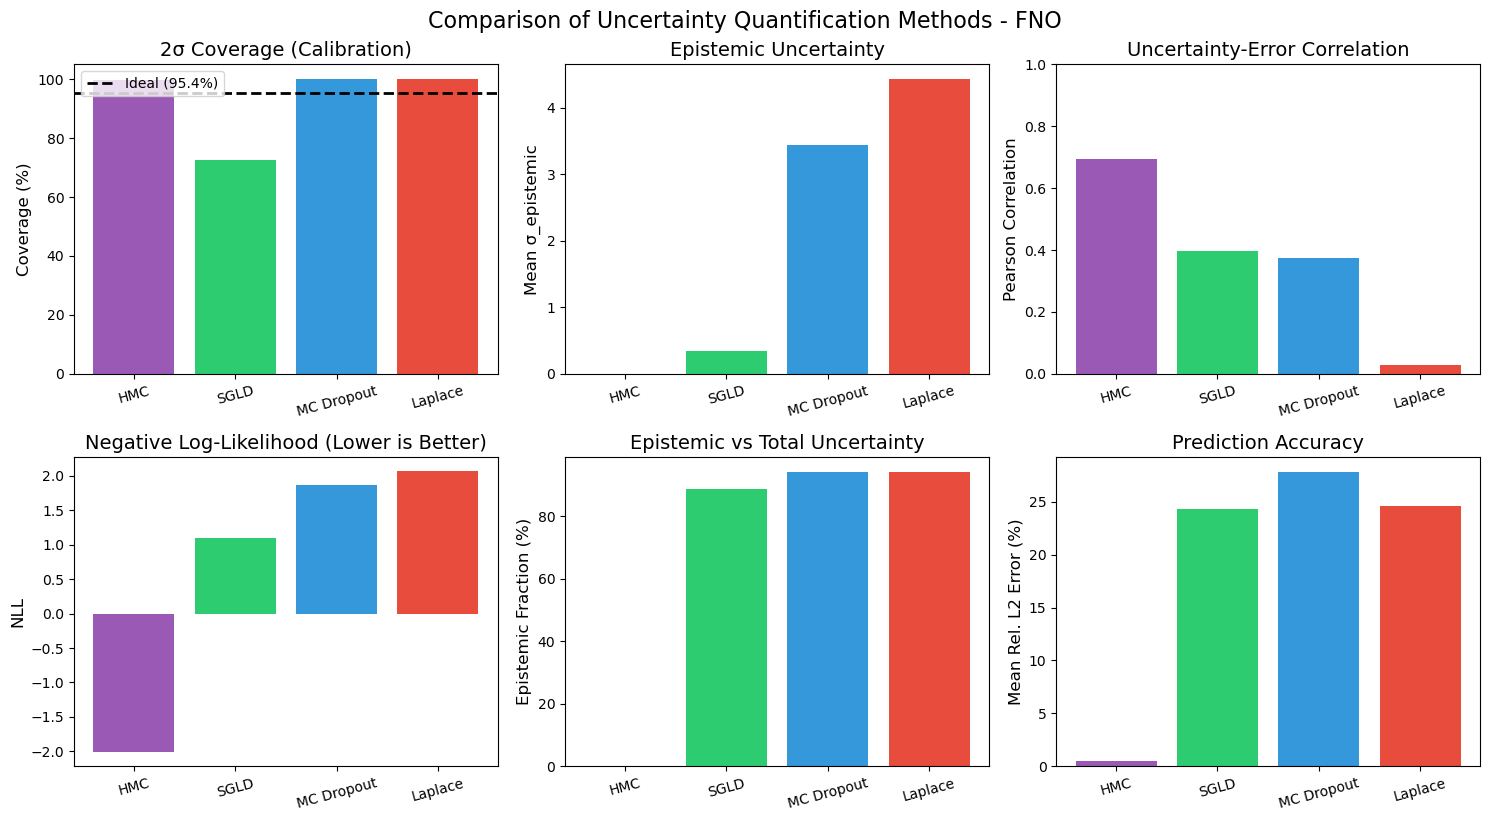

In [13]:
uq.comparison_plotting(hmc_metrics, sgld_metrics, mcd_metrics, la_metrics)

## Behaviour on OOD data

In [ ]:
data_1 = DataProcessorFNO(data_folder + data_prefix + '_FNO_samples_ood-0.1.npz', 100, 400, num_Y_components, coarsen_grid_factor)
data_ood_1 = {'X_train': data_1.X_test, 'Y_train': data_1.Y_test}
data_2 = DataProcessorFNO(data_folder + data_prefix + '_FNO_samples_ood-0.2.npz', 100, 400, num_Y_components, coarsen_grid_factor)
data_ood_2 = {'X_train': data_2.X_test, 'Y_train': data_2.Y_test}
data_3 = DataProcessorFNO(data_folder + data_prefix + '_FNO_samples_ood-0.3.npz', 100, 400, num_Y_components, coarsen_grid_factor)
data_ood_1 = {'X_train': data_3.X_test, 'Y_train': data_3.Y_test}
data__1 = DataProcessorFNO(data_folder + data_prefix + '_FNO_samples_ood--0.1.npz', 100, 400, num_Y_components, coarsen_grid_factor)
data_ood__1 = {'X_train': data__1.X_test, 'Y_train': data__1.Y_test}  

In [ ]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
hmc_metrics_1, hmc_std_1 = uq.uqevaluation(data_ood, model, data, 'hmc', hmc_samples=hmc_samples.clone())

std_4 = []
results_4 = []
for i in range(3):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    result4_i,std_4_i = uq.uqevaluation(data_shifting_data[i], model, data_shifting[i], 'hmc', hmcsamples=hmc_samples.clone())
    print(f" Complete {i+1} epoch")
    std_4.append(std4_i)
    results_4.append(result4_i)
model.to(device)
std4_4, result4_4 = uq.uqevaluation(data_ood__1, model, data__1, 'hmc', hmcsamples=hmc_samples.clone())
print(" Complete 4 epoch")


1. PREDICTION ACCURACY:
   RMSE: 5.102976
   MAE:  2.018241
   Mean Relative L2 Error: 108.62%
   Std Relative L2 Error:  48.32%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 10.3% (ideal: 68.3%)
   Coverage within 2σ: 14.4% (ideal: 95.4%)
   Coverage within 3σ: 18.2% (ideal: 99.7%)
   Status: UNDER-CONFIDENT (uncertainties too large)

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 0.002292
   Mean Total σ:     0.050393
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.960
   → Good! High uncertainty correlates with high error

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 0.9%
   Aleatoric fraction: 99.1%
   → Data noise dominates (model is confident)

6. PROPER SCORING RULES:
   Negative Log-Likelihood: 2752.4026
   (Lower is better)



In [ ]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
sgld_metrics_1, sgld_mean_1, sgld_std_1 = uq.uqevaluation(data_ood, model, data, 'sgld', sgld_samples=sgld_samples.clone())

std_5 = []
results_5 = []
for i in range(3):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    result5_i, std5_i = uq.uqevaluation(data_shifting_data[i], model, data_shifting[i], 'sgld', sgld_samples=sgld_samples.clone())
    print(f" Complete {i+1} epoch")
    std_5.append(std4_i)
    results_4.append(result4_i)
model.to(device)
std5_4, result5_4 = uq.uqevaluation(data_oo1__1, model, data__1, 'sgld', sgld_samples=sgld_samples.clone())
print(" Complete 4 epoch")



1. PREDICTION ACCURACY:
   RMSE: 5.292713
   MAE:  2.790447
   Mean Relative L2 Error: 123.31%
   Std Relative L2 Error:  44.61%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 23.0% (ideal: 68.3%)
   Coverage within 2σ: 40.6% (ideal: 95.4%)
   Coverage within 3σ: 59.1% (ideal: 99.7%)
   Status: UNDER-CONFIDENT (uncertainties too large)

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 0.850254
   Mean Total σ:     0.855594
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.931
   → Good! High uncertainty correlates with high error

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 92.3%
   Aleatoric fraction: 7.7%
   → Model uncertainty dominates

6. PROPER SCORING RULES:
   Negative Log-Likelihood: 14.1301
   (Lower is better)



In [ ]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
uq.inject_dropout(model)
torch.nn.Module.train(model)
# Enable dropout for both Dropout and Dropout2d layers
for module in model.modules():
    if isinstance(module, (torch.nn.Dropout, torch.nn.Dropout2d)):
        torch.nn.Module.train(module)
# MC Dropout Comprehensive Evaluation
mcd_metrics_1, mcd_mean_1, mcd_std_1 = uq.uqevaluation(data_ood, model, data, 'mcd')

std_7 = []
results_7 = []
for i in range(3):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    uq.inject_dropout(model)
    torch.nn.Module.train(model)
    for module in model.modules():
        if isinstance(module, (torch.nn.Dropout, torch.nn.Dropout2d)):
            torch.nn.Module.train(module)
    std7_i, result7_i = uq.uqevaluation(data_shifting_data[i], model, data_shifting[i], 'mcd')
    std_7.append(std7_i)
    results_7.append(result7_i)
    print(f" Complete {i+1} epoch")
model = torch.load(model_save_file, weights_only=False)
model.to(device)
uq.inject_dropout(model)
torch.nn.Module.train(model)
for module in model.modules():
    if isinstance(module, (torch.nn.Dropout, torch.nn.Dropout2d)):
        torch.nn.Module.train(module)
std7_4, result7_4 = uq.uqevaluation(data_ood__1, model, data__1, 'mcd')
print(f" Complete {4} epoch")


Running MC Dropout sampling...
MC Dropout predictions shape: (100, 600, 51, 51, 1)

1. PREDICTION ACCURACY:
   RMSE: 5.907424
   MAE:  3.064135
   Mean Relative L2 Error: 132.77%
   Std Relative L2 Error:  51.86%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 95.0% (ideal: 68.3%)
   Coverage within 2σ: 98.7% (ideal: 95.4%)
   Coverage within 3σ: 99.4% (ideal: 99.7%)
   Status: WELL-CALIBRATED

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 8.013516
   Mean Total σ:     8.016668
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.946
   → Good! High uncertainty correlates with high error

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 94.2%
   Aleatoric fraction: 5.8%
   → Model uncertainty dominates

6. PROPER SCORING RULES:
   Negative Log-Likelihood: 2.6271
   (Lower is better)



In [ ]:
model = torch.load(model_save_file, weights_only=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
la_metrics_1, la_mean_1, la_std_1  = uq.uqevaluation(data_ood, model, data, 'la', la_samples=la_samples.clone())

std_7 = []
results_7 = []
for i in range(3):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    result7_i, std7_i = uq.uqevaluation(data_shifting_data[i], model, 'la', lasamples=la_samples.clone())
    std_7.append(std7_i)
    results_7.append(result7_i)
    print(f" Complete {i+1} epoch")
model = torch.load(model_save_file, weights_only=False)
model.to(device)
std7_4, result7_4 = uq.uqevaluation(data_ood__1, model, 'la', lasamples=la_samples.clone())


1. PREDICTION ACCURACY:
   RMSE: 4.966193
   MAE:  1.948830
   Mean Relative L2 Error: 106.85%
   Std Relative L2 Error:  44.83%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 98.2% (ideal: 68.3%)
   Coverage within 2σ: 99.7% (ideal: 95.4%)
   Coverage within 3σ: 99.9% (ideal: 99.7%)
   Status: OVER-CONFIDENT (uncertainties too small)

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 10.151782
   Mean Total σ:     10.154821
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.834
   → Good! High uncertainty correlates with high error

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 94.3%
   Aleatoric fraction: 5.7%
   → Model uncertainty dominates

6. PROPER SCORING RULES:
   Negative Log-Likelihood: 2.8761
   (Lower is better)




Metric                             HMC         SGLD   MC Dropout      Laplace      Ideal
----------------------------------------------------------------------------------------------------
RMSE                          5.102976     5.292713     5.907424     4.966193      Lower
MAE                           2.018241     2.790447     3.064135     1.948830      Lower
Mean Rel. L2 Error (%)          108.62       123.31       132.77       106.85      Lower
Coverage 1σ (%)                   10.3         23.0         95.0         98.2       68.3
Coverage 2σ (%)                   14.4         40.6         98.7         99.7       95.4
Coverage 3σ (%)                   18.2         59.1         99.4         99.9       99.7
Mean Epistemic σ              0.002292     0.850254     8.013516    10.151782          -
Mean Total σ                  0.050393     0.855594     8.016668    10.154821          -
Epistemic Fraction (%)             0.9         92.3         94.2         94.3          -
Uncertai

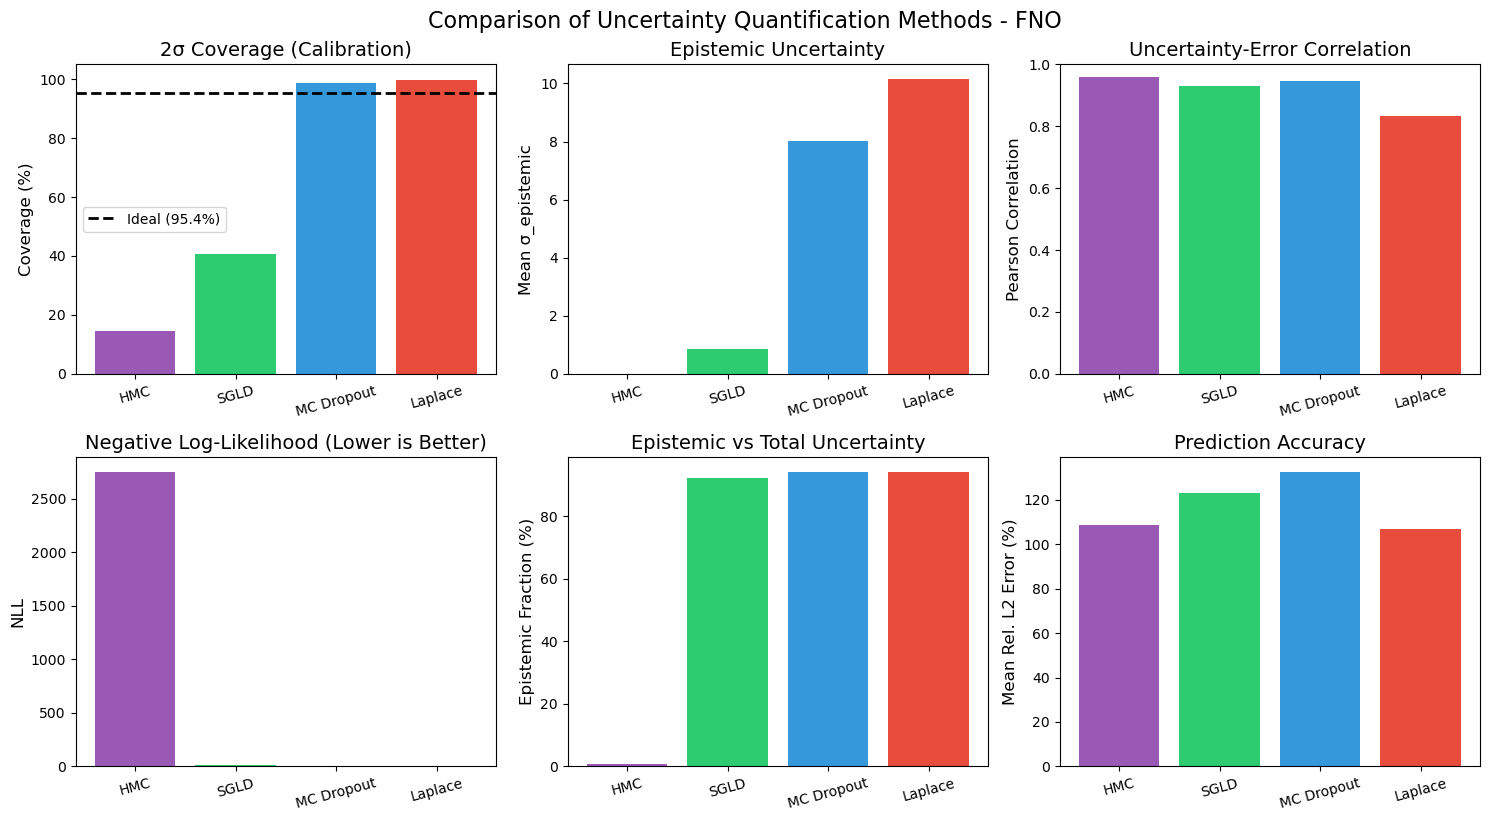

In [ ]:
uq.comparison_plotting(result_4, result_5, result_6, result_7)

## Data Shifting

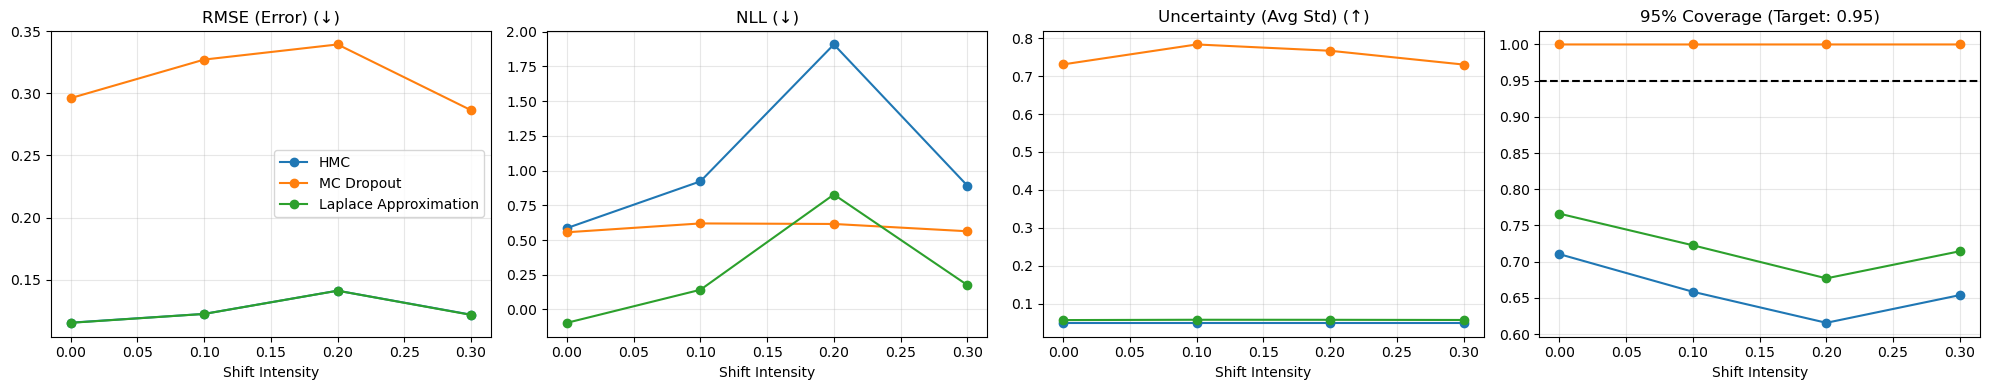

In [ ]:
method = ['HMC','SGLD', 'MC Dropout', 'Laplace Approximation']
levels = [0, 0.1, 0.2, 0.3]
results_4 = [hmc_metrics] + results_4
results_5 = [sgld_metrics] + results_5
results_6 = [mcd_metrics] + results_6
results_7 = [la_metrics] + results_7
results = [results_4, results_5, results_6, results_7]
uq.run_regression_shift(method, levels, results)

## ood data detection

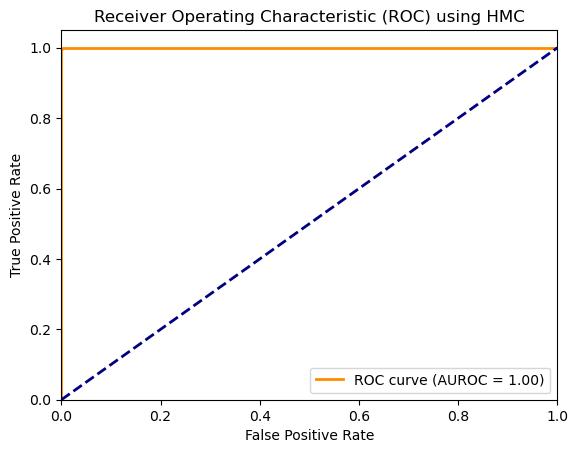

AUROC for OOD detection: 0.9998916666666666


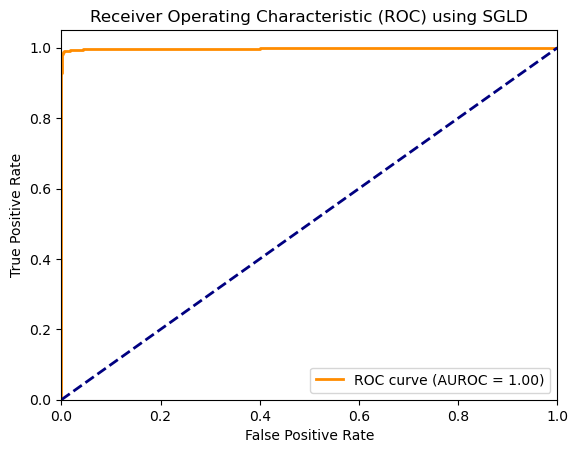

AUROC for OOD detection: 0.9977600000000001


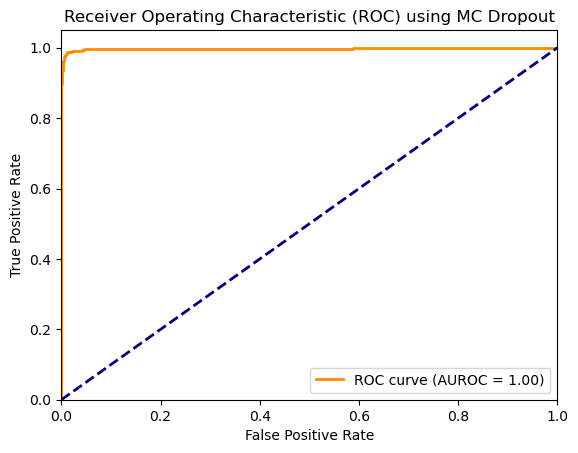

AUROC for OOD detection: 0.9971633333333333


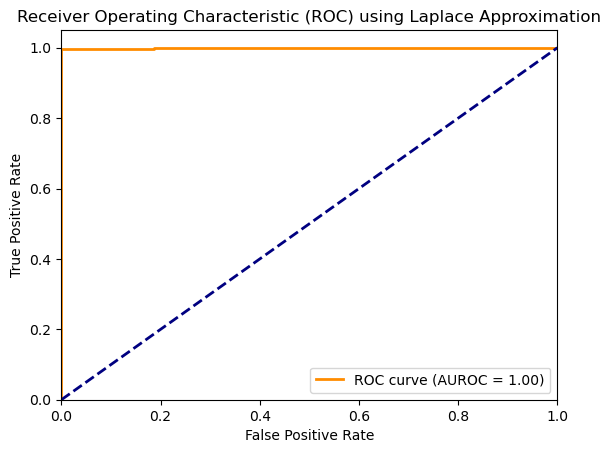

AUROC for OOD detection: 0.9987066666666666


In [ ]:
std4 = np.concatenate(std_4, axis=0)
std4 = np.concatenate((std4, std4_4),axis=0)
hmc_ood_eval = np.concatenate((std1.mean(axis=1),std4.mean(axis=1)), axis=0)  # epistemic + aleatoric
hmc_ood_eval = hmc_ood_eval/np.max(hmc_ood_eval)
std5 = np.concatenate(std_5, axis=0)
std5 = np.concatenate((std5, std5_4),axis=0)
mcd_ood_eval = np.concatenate((std2.mean(axis=1),std5.mean(axis=1)), axis=0)
mcd_ood_eval = mcd_ood_eval/np.max(mcd_ood_eval)
std6 = np.concatenate(std_6, axis=0)
std6 = np.concatenate((std6, std6_4),axis=0)
la_ood_eval = np.concatenate((std3.mean(axis=1),std6.mean(axis=1)), axis=0)
la_ood_eval = la_ood_eval/np.max(la_ood_eval)
oods = np.concatenate((np.zeros(std1.shape[0]), np.ones(std4.shape[0])), axis=0)  # 0 for ID, 1 for OOD
#Examine OOD data:
# Step 1: Generate uncertainty scores: ood_eval
# Step 2: Create true labels for AUROC (1 for OOD, 0 for ID): oods
# Step 3: Calculate AUROC
for ood, uqmethod in zip([hmc_ood_eval, sgld_ood_eval, mcd_ood_eval, la_ood_eval], ['HMC', 'SGLD', 'MC Dropout', 'Laplace Approximation']):
    auroc = roc_auc_score(oods, ood)
    fpr, tpr, _ = roc_curve(oods, ood)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUROC = {auroc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) using {uqmethod}')
    plt.legend(loc='lower right')
    plt.show()
    print(f"AUROC for OOD detection: {auroc}")


## Conformal Prediction

In [ ]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
alpha = 0.1  # Target error rate (90% coverage)
n_cal = 500  # Number of samples for calibration

# Split remaining test data into calibration and final test
indices = np.arange(num_test)
np.random.shuffle(indices)
cal_idx = indices[:n_cal]
test_idx = indices[n_cal:]

# Get predictions for calibration set
x_branch_cal = test_data['X_train'][cal_idx]
y_cal = test_data['Y_train'][cal_idx]

with torch.no_grad():
    x_b = torch.from_numpy(x_branch_cal).float().to(device)
    y_cal_pred = model.predict(x_b).cpu().numpy()

# Calculate non-conformity scores (Absolute Residuals)
# For vector outputs, we use point-wise absolute error
scores = np.abs(y_cal - y_cal_pred)

# Compute the (1-alpha) quantile of the scores
q_level = np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
qhat = np.quantile(scores, q_level, axis=0) # Point-wise quantile

print(f"Calibration complete using {n_cal} samples.")
print(f"Quantile (qhat) mean value: {qhat.mean():.4f}")

Calibration complete using 500 samples.
Quantile (qhat) mean value: 0.1708


In [ ]:
# Evaluate on the remaining test set
x_b_final = np.array([])
y_test_final = np.array([])
for datas, x_branch_final, y_test_final in zip([data, data_1, data_2, data_3, data__1],\
    [test_data['X_train'][test_idx], data_shifting_data[0]['X_train'], data_shifting_data[1]['X_train'], data_shifting_data[2]['X_train'], data_ood__1['X_train']], \
    [test_data['Y_train'][test_idx], data_shifting_data[0]['Y_train'], data_shifting_data[1]['Y_train'], data_shifting_data[2]['Y_train'], data_ood__1['Y_train']]):
    with torch.no_grad():
        x_b_final = torch.from_numpy(x_branch_final).float().to(device)
        y_test_pred = model.predict(x_b_final, x_t).cpu().numpy()
        y_test_pred = datas.decoder_Y(y_test_pred)
    y_test_final = np.concatenate((y_test_final, y_test_pred), axis=0)

# Prediction Intervals: [pred - qhat, pred + qhat]
lower_bound = y_test_pred - qhat
upper_bound = y_test_pred + qhat

# Calculate empirical coverage
cover = ((y_test_final >= lower_bound) & (y_test_final <= upper_bound)).mean(axis=1)
coverage = cover.mean()
cover_id = cover[:len(test_idx)]
cover_ood = cover[len(test_idx):]
cover_id_mean = cover_id.mean() 
cover_ood_mean = cover_ood.mean()

print(f"Results for alpha = {alpha} (Target Coverage: {1-alpha:.1%})")
print(f"Empirical Test Coverage: {coverage:.1%}")
print(f"ID Coverage: {cover_id_mean:.1%}")
print(f"OOD Coverage: {cover_ood_mean:.1%}")
print(f"Average Prediction Interval Width: {(upper_bound - lower_bound).mean():.4f}")

Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 71.6%
ID Coverage: 90.3%
OOD Coverage: 65.7%
Average Prediction Interval Width: 0.3415


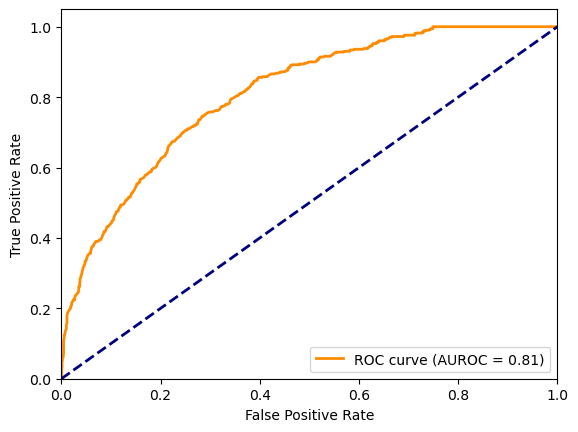

AUROC for OOD detection: 0.809458125


In [ ]:
oods = np.concatenate((np.ones(len(test_idx)), np.zeros(len(x_branch_final)-len(test_idx))), axis=0)
#Examine OOD data:
# Step 1: Generate uncertainty scores: ood_eval
# Step 2: Create true labels for AUROC (1 for OOD, 0 for ID): oods
# Step 3: Calculate AUROC

auroc = roc_auc_score(oods, cover)
fpr, tpr, _ = roc_curve(oods, cover)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUROC = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
print(f"AUROC for OOD detection: {auroc}")